1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

df = pd.read_csv("https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv",index_col = 0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [2]:
df = df.replace("No",0).replace("Yes",1)
df.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color of the outcome of `default` labeled red if yes and blue if no. 

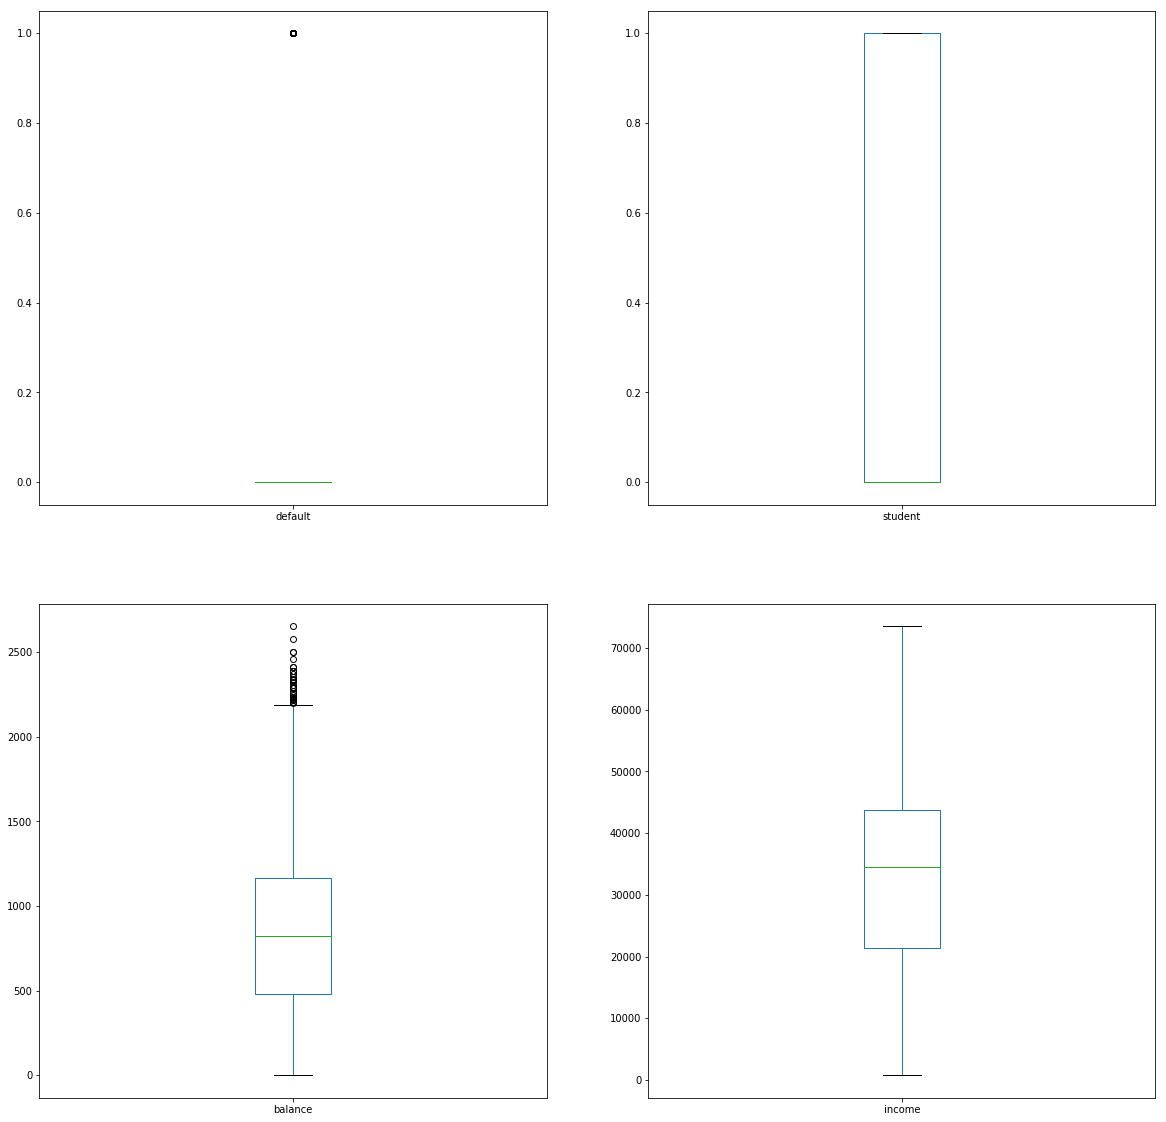

In [3]:
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(2,2,1)
df["default"].plot.box()
ax2 = fig.add_subplot(2,2,2)
df["student"].plot.box()
ax3 = fig.add_subplot(2,2,3)
df["balance"].plot.box()
ax4 = fig.add_subplot(2,2,4)
df["income"].plot.box()

plt.show()

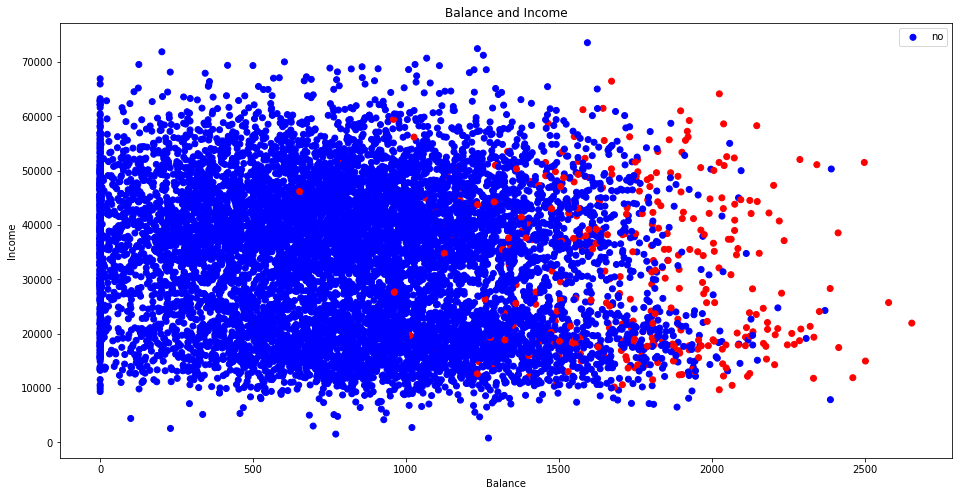

In [4]:
colors= {0:"blue",1:"red"}
plt.figure(figsize=(16,8))
plt.scatter(df["balance"],df["income"],c = df["default"].apply(lambda x:colors[x]))
plt.title("Balance and Income")
plt.xlabel("Balance")
plt.ylabel("Income")
plt.legend(('no','yes'))
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

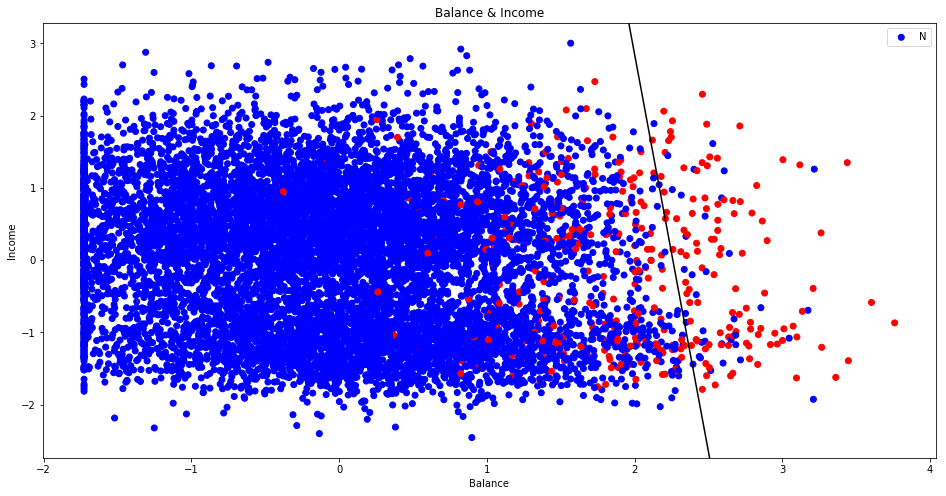

In [5]:
# Split Data
X = df[["balance","income"]]
y = df["default"]
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 50)

# Training model
regr = LogisticRegression(penalty = "l1")
model1 = regr.fit(X_train,y_train)

# Scatter Plot
colors= {0:"blue",1:"red"}
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(X[:,0],X[:,1],c = df["default"].apply(lambda x:colors[x]))
plt.title("Balance & Income")
plt.xlabel("Balance")
plt.ylabel("Income")
plt.legend('No')

# Decision Boundary 
b = model1.intercept_
coef = model1.coef_[0]
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
x = np.arange(x_min, x_max, 1)
y = (b + coef[0] * x) / -coef[1]

plt.plot(x, y, c='black')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

Area under the ROC curve : 0.957250


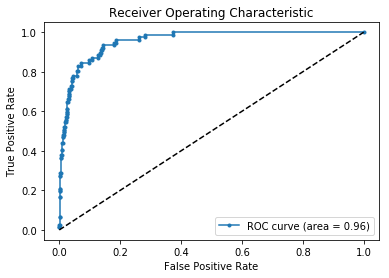

In [6]:
def generate_auc(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    random_state = np.random.RandomState(0)
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

Area under the ROC curve : 0.957912


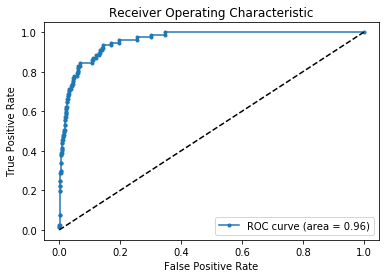

With the added variable, the performance did not impove a lot.
The coefficients for balance, income and student are shown respectively: [ 0.06172524  0.00212686 -0.00427   ].


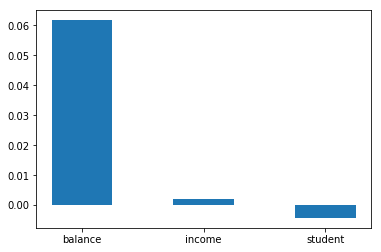

In [19]:
# Add Variable 'Student'
X = df[['balance','income','student']]
y = df['default']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 50)

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
generate_ROCplot(fpr,tpr,'LR',roc_auc)

alphas = np.logspace(-6, -1, 100)
score = []
for alpha in alphas:
    clf = Ridge(alpha=alpha)
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))
opt_index = np.array(score).argmax()

clf = Ridge(alpha=alphas[opt_index])
clf.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), clf.coef_, 0.5)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('balance', 'income', 'student'))
rects = ax.patches
print("With the added variable, the performance did not impove a lot.")
print ('The coefficients for balance, income and student are shown respectively: {0}.'.format(clf.coef_))
plt.show()

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [24]:
scores = cross_val_score(regr, X_train, y_train, cv=5)
print(scores)
print("According to the cross valdiation score, the model is robust.")

[0.97688944 0.9725     0.97375    0.97125    0.97560976]
According to the cross valdiation score, the model is robust.


7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

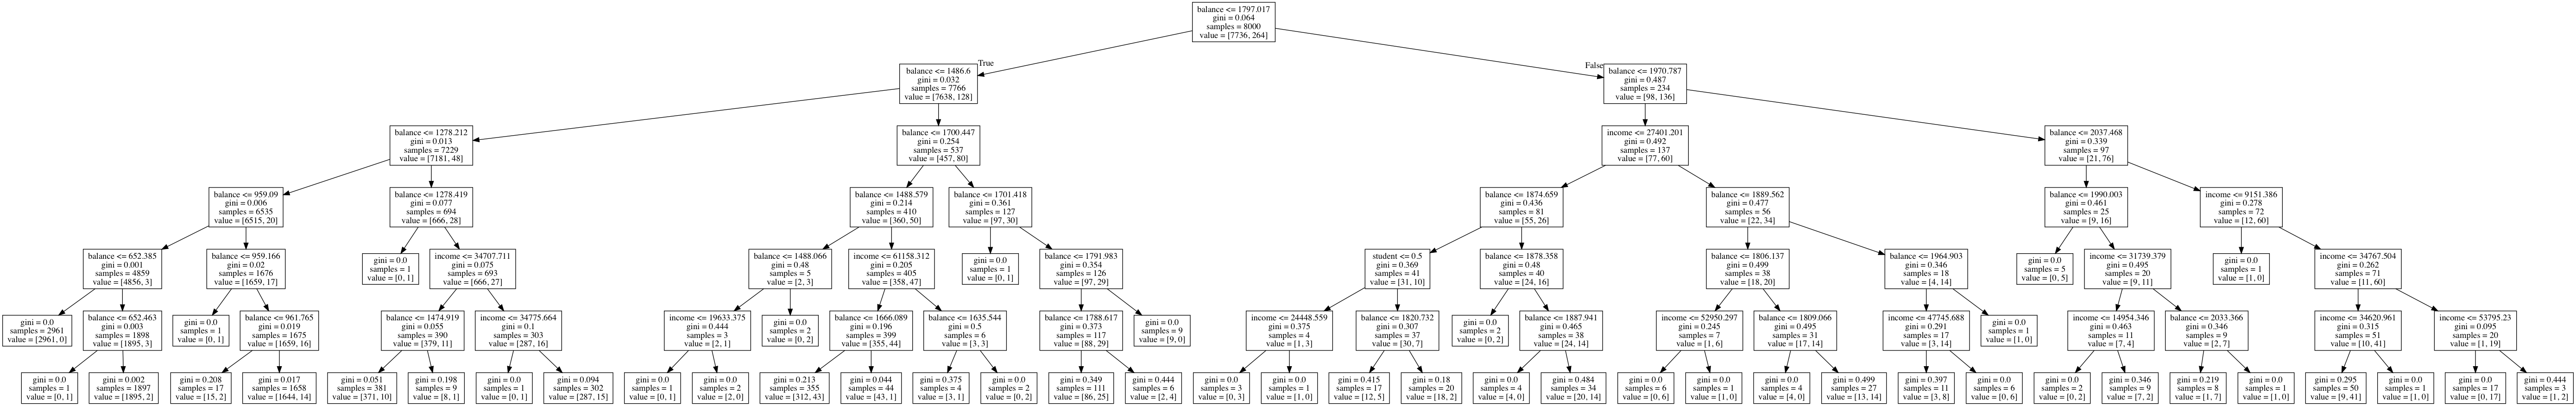

In [22]:
import pydotplus
X = df.drop(["default"],1)
y = df.default
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

dt=DecisionTreeClassifier(max_depth=6)
dt.fit(X_train, y_train)

dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


In [23]:
print("Comparing the result of decision tree and linear regression approaches, they have similar performance.")

Comparing the result of decision tree and linear regression approaches, they have similar performance.


8) Find the optimal decision tree depth and compute the AUC ROC. 

Optimal Depth: 5.


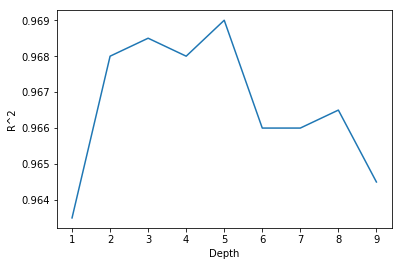

In [13]:
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,10)
for n in depths:
    dt = DecisionTreeClassifier(max_depth=n)
    # Train the model using the training sets
    dt.fit(X_train, y_train)
    train_errors.append(dt.score(X_train,y_train))
    scores.append(dt.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors = scores
n_opt = depths[np.argmax(scores)]
print("Optimal Depth: {0}.".format(n_opt))
plt.show()

Area under the ROC curve : 0.932550


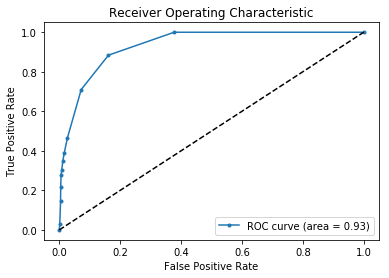

Max Depth = 4
Area under the ROC curve : 0.921757


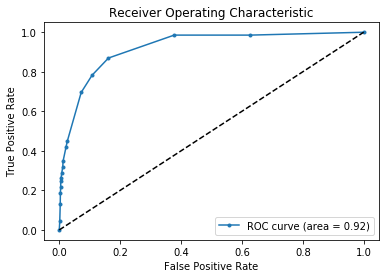

Max Depth = 5
Area under the ROC curve : 0.904683


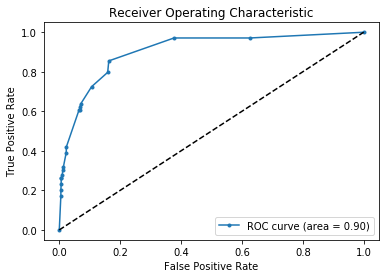

Max Depth = 6
According to ROC figures, the depth of 4 seems a little bit better than the depth of 5.


In [14]:
# Different Max Depth = 4
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 4)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 4')

# Different Max Depth = 5
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 5)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 5')

# Different Max Depth = 6
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 6)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 6')

print('According to ROC figures, the depth of 4 seems a little bit better than the depth of 5.')